In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Patch

import pandas as pd

# Turn off logging for NUTS sampler for PyMCMC
import logging

logger = logging.getLogger("pymc")
logger.setLevel(logging.ERROR)

## Evaluating and Selecting Models—Bayesian Edition

Last session, we looked at some tools for model selection with frequentist models. In particular, we looked at AIC and BIC as tools to compare models.

For Bayesian models, the 'confidence' of the model is easily seen by the spread of the estimates, however this is different to the model's performance. To assess model performance we recommend the ELPD ('expected log predictive density'). This can be calculated *either* with LOO (leave-one-out) for with WAIC (widely applicable information criterion); we recommend LOO.

To explain the intuition behind ELPD, consider the plot from the first sprint:

![plot](./linear_preds.png)

For observations (blue) that are in areas with a lot of predictions (orange), the *predictive density* is high. For observations by themselves (few predictions) the predictive density is low. By leaving out each observation in turn (LOO) and considering the density in that area, we get a feel for how well the model predicts in general.


## Example 1—Using the wrong model

First we'll look at what happens if we use a model without mixed effects for the data from last sprint.

In [2]:
rng = np.random.default_rng(seed=42)

In [3]:
spelling = pd.read_csv(
    "../../datasets/spelling/spelling.tsv", sep="\t", encoding="Windows-1252"
)
spelling

,subject_ID,lemma,gender,age,education,grade,error
0,325,aanbidden,male,17,general,Gr3,0
1,563,aanbidden,female,18,technical,Gr3,0
2,742,aanbieden,male,18,vocational,Gr3,0
3,899,aanbieden,male,17,vocational,Gr3,0
4,625,aanbieden,female,16,general,Gr2,0
...,...,...,...,...,...,...,...
5820,website88,worden,female,17,general,Gr3,0
5821,website88,worden,female,17,general,Gr3,0
5822,website88,worden,female,17,general,Gr3,0
5823,325,zenden,male,17,general,Gr3,0


> NOTE: To perform the ELPD comparisons, we need to tell the fitting method to preserve "log-likelihood outcomes", using the slightly weird incantation:

`idata_kwargs={"log_likelihood": True}`

(this is not done by default because it's a little bit slower. An unfortunate choice in our view...)


In [4]:
model_hierarchical = bmb.Model(
    "error ~ 0 + gender + education + grade + (1|lemma) + (1|subject_ID) ",
    spelling,
    family="bernoulli",
)
idata_hierarchical = model_hierarchical.fit(
    target_accept=0.9,
    random_seed=rng,
    progressbar=False,
    idata_kwargs={"log_likelihood": True},
)
az.summary(idata_hierarchical, var_names=["gender", "education", "grade"])

Modeling the probability that error==1


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gender[female],-0.934,0.250,-1.403,-0.474,0.010,0.007,570.0,1112.0,1.01
gender[male],-0.540,0.259,-1.047,-0.085,0.010,0.007,612.0,1360.0,1.00
education[technical],0.844,0.147,0.575,1.134,0.004,0.003,1091.0,1657.0,1.00
education[vocational],1.248,0.158,0.958,1.559,0.004,0.003,1268.0,2237.0,1.00
grade[Gr3],-0.238,0.098,-0.420,-0.048,0.002,0.002,1808.0,2146.0,1.00


In [5]:
model_non_hierarchical = bmb.Model(
    "error ~ 0 + gender + education + grade ",
    spelling,
    family="bernoulli",
)
idata_non_hierarchical = model_non_hierarchical.fit(
    progressbar=False,
    idata_kwargs={"log_likelihood": True},
)

Modeling the probability that error==1


First we use a "forest plot" to compare the "high density interval" for each predictor. This plot tells us how confident the models are in their estimates. 

Here we have added a custom "transform" to graph the results as Odds (which are easier to understand than logistic model parameters), but it is only for clarity. The main thing to notice is that the most likely parameters for the two models are not _so_ different, but the spread changes a lot!

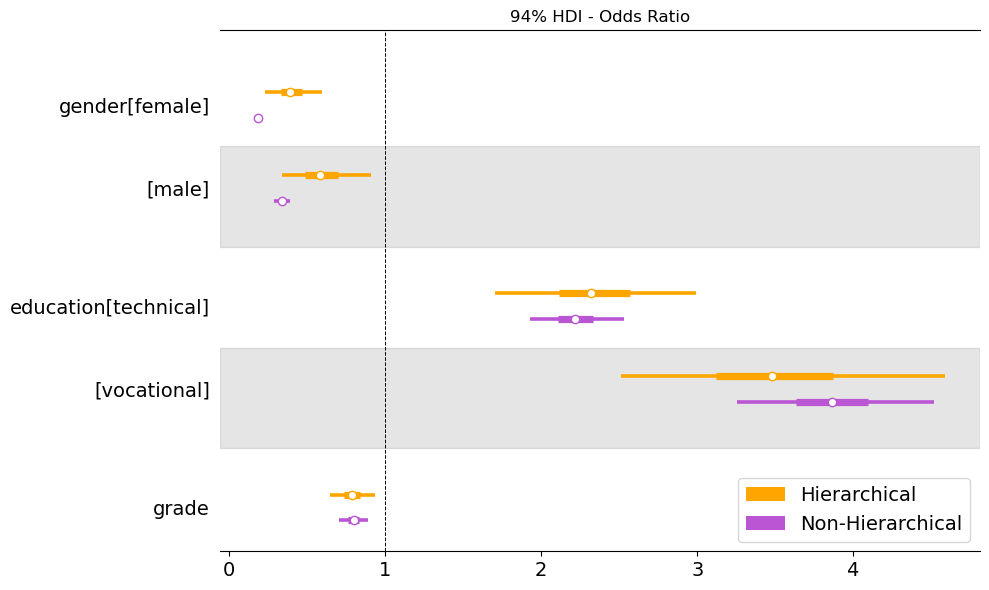

In [6]:
_, ax = plt.subplots(figsize=(10, 6))

# Create forestplot with ArviZ, only for the mean.
az.plot_forest(
    [
        idata_hierarchical,
        idata_non_hierarchical,
    ],
    var_names=["gender", "education", "grade"],
    combined=True,
    colors=["orange", "mediumorchid"],
    transform=lambda x: np.exp(x),
    linewidth=2.6,
    markersize=8,
    ax=ax,
)

# Create legend
handles = [
    Patch(label="Hierarchical", facecolor="orange"),
    Patch(label="Non-Hierarchical", facecolor="mediumorchid"),
]

ax.set(
    title="94% HDI - Odds Ratio",
)
ax.axvline(1, linestyle="--", color="black", linewidth=0.7)
legend = ax.legend(handles=handles, loc=4, fontsize=14, frameon=True, framealpha=0.8)
plt.tight_layout()
plt.show()

> EXERCISE: How do you interpret the Odds Ratios?

## Confidently Wrong

Note how the Non-Hierarchical model has tighter estimates! This is because from its point of view there are **many more observations** because the students are not grouped. In other words the students for whom there are many records (they were tested on many words) are treated as if they are all different people. This not only makes the model incorrect (because of bias) but also makes it more confident (because it thinks it has more observations).

> IMPORTANT Just because a model has tight estimates does not mean that it is good or correct!

## ELPD Comparison Plot
There is a built in plot to calculate the ELPD, and compare the predictive power of the models using the LOO method as described. This will automatically rank the models. Higher ELPD is better (and the plot arranges them so the models are ranked from top to bottom). The theory is very complicated, but it is similar 'in spirit' to the AIC/BIC measures. In particular, the ELPD also considers the effective number of parameters to automatically penalise models with more parameters.

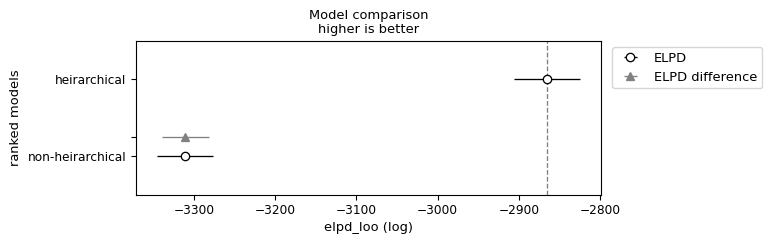

In [7]:
comp = az.compare(
    {
        "heirarchical": idata_hierarchical,
        "non-heirarchical": idata_non_hierarchical,
    }
)
az.plot_compare(comp)
plt.show()

## Example 2—Model Comparison

Once again, opinions differ regarding 'exploratory' analysis, but for the sake of argument, here we repeat the model comparison from last session, but in Bayesian style. Because the models can take a while to fit, we compare just the top 10 models from the AIC/BIC comparisons.

In [8]:
df = pd.read_csv("../../datasets/gries/05-2_reactiontimes.csv", sep="\t")
df["LENGTH"] = df.CASE.str.len()
df["IMAGEABILITY"] = df.IMAGEABILITY.astype(
    pd.api.types.CategoricalDtype(categories=["lo", "hi"], ordered=True)
)
df["FAMILIARITY"] = df.FAMILIARITY.astype(
    pd.api.types.CategoricalDtype(categories=["lo", "med", "hi"], ordered=True)
)
df

,CASE,RT,FREQUENCY,FAMILIARITY,IMAGEABILITY,MEANINGFULNESS,LENGTH
0,almond,650.9947,0.693147,NaN,NaN,NaN,6
1,ant,589.4347,1.945910,med,hi,415.0,3
2,apple,523.0493,2.302585,hi,hi,451.0,5
3,apricot,642.3342,0.693147,lo,lo,NaN,7
4,asparagus,696.2092,0.693147,med,lo,442.0,9
...,...,...,...,...,...,...,...
72,tortoise,733.0323,1.386294,lo,lo,403.0,8
73,walnut,663.5908,2.484907,med,lo,468.0,6
74,wasp,725.7056,1.098612,NaN,NaN,NaN,4
75,whale,609.9745,0.000000,med,hi,474.0,5


In [9]:
models = [
    "FAMILIARITY + MEANINGFULNESS + LENGTH",
    "MEANINGFULNESS + LENGTH",
    "MEANINGFULNESS*LENGTH",
    "FREQUENCY + FAMILIARITY + MEANINGFULNESS + LENGTH",
    "FAMILIARITY + IMAGEABILITY + MEANINGFULNESS + LENGTH",
    "FREQUENCY + MEANINGFULNESS + LENGTH",
    "IMAGEABILITY + MEANINGFULNESS + LENGTH",
    "FREQUENCY + FAMILIARITY + IMAGEABILITY + LENGTH",
    "FREQUENCY + IMAGEABILITY + MEANINGFULNESS + LENGTH",
    "FAMILIARITY + IMAGEABILITY + LENGTH",
    "FREQUENCY + FAMILIARITY + LENGTH",
]

In [10]:
# Run each model, store each inference data object in a dict

results = {}
for m in models:
    print(f"Fitting: {m}")
    model = bmb.Model(
        f"RT ~ {m}",
        df.dropna(),
    )
    idata = model.fit(
        progressbar=False,
        idata_kwargs={"log_likelihood": True},
    )
    results[m] = idata

Fitting: FAMILIARITY + MEANINGFULNESS + LENGTH
Fitting: MEANINGFULNESS + LENGTH
Fitting: MEANINGFULNESS*LENGTH
Fitting: FREQUENCY + FAMILIARITY + MEANINGFULNESS + LENGTH
Fitting: FAMILIARITY + IMAGEABILITY + MEANINGFULNESS + LENGTH
Fitting: FREQUENCY + MEANINGFULNESS + LENGTH
Fitting: IMAGEABILITY + MEANINGFULNESS + LENGTH
Fitting: FREQUENCY + FAMILIARITY + IMAGEABILITY + LENGTH
Fitting: FREQUENCY + IMAGEABILITY + MEANINGFULNESS + LENGTH
Fitting: FAMILIARITY + IMAGEABILITY + LENGTH
Fitting: FREQUENCY + FAMILIARITY + LENGTH


## Comparison Plot

The plots have two components:
- ELPD (with credible interval) is the overal predictive power of the model
- ELPD difference (in grey) is the **difference** from the reference (best) model.

The ELPD difference is probably the most important. Note that the `FAMILIARITY + MEANINGFULNESS + LENGTH` model is probably worse than the reference model, but that the difference line crosses over, so it is not certainly worse. The second-best model by ELPD (`FREQUENCY + MEANINGFULNESS + LENGTH`) is almost certainly worse (but not by much). These results are qualitatively similar to the conclusions we drew last session.

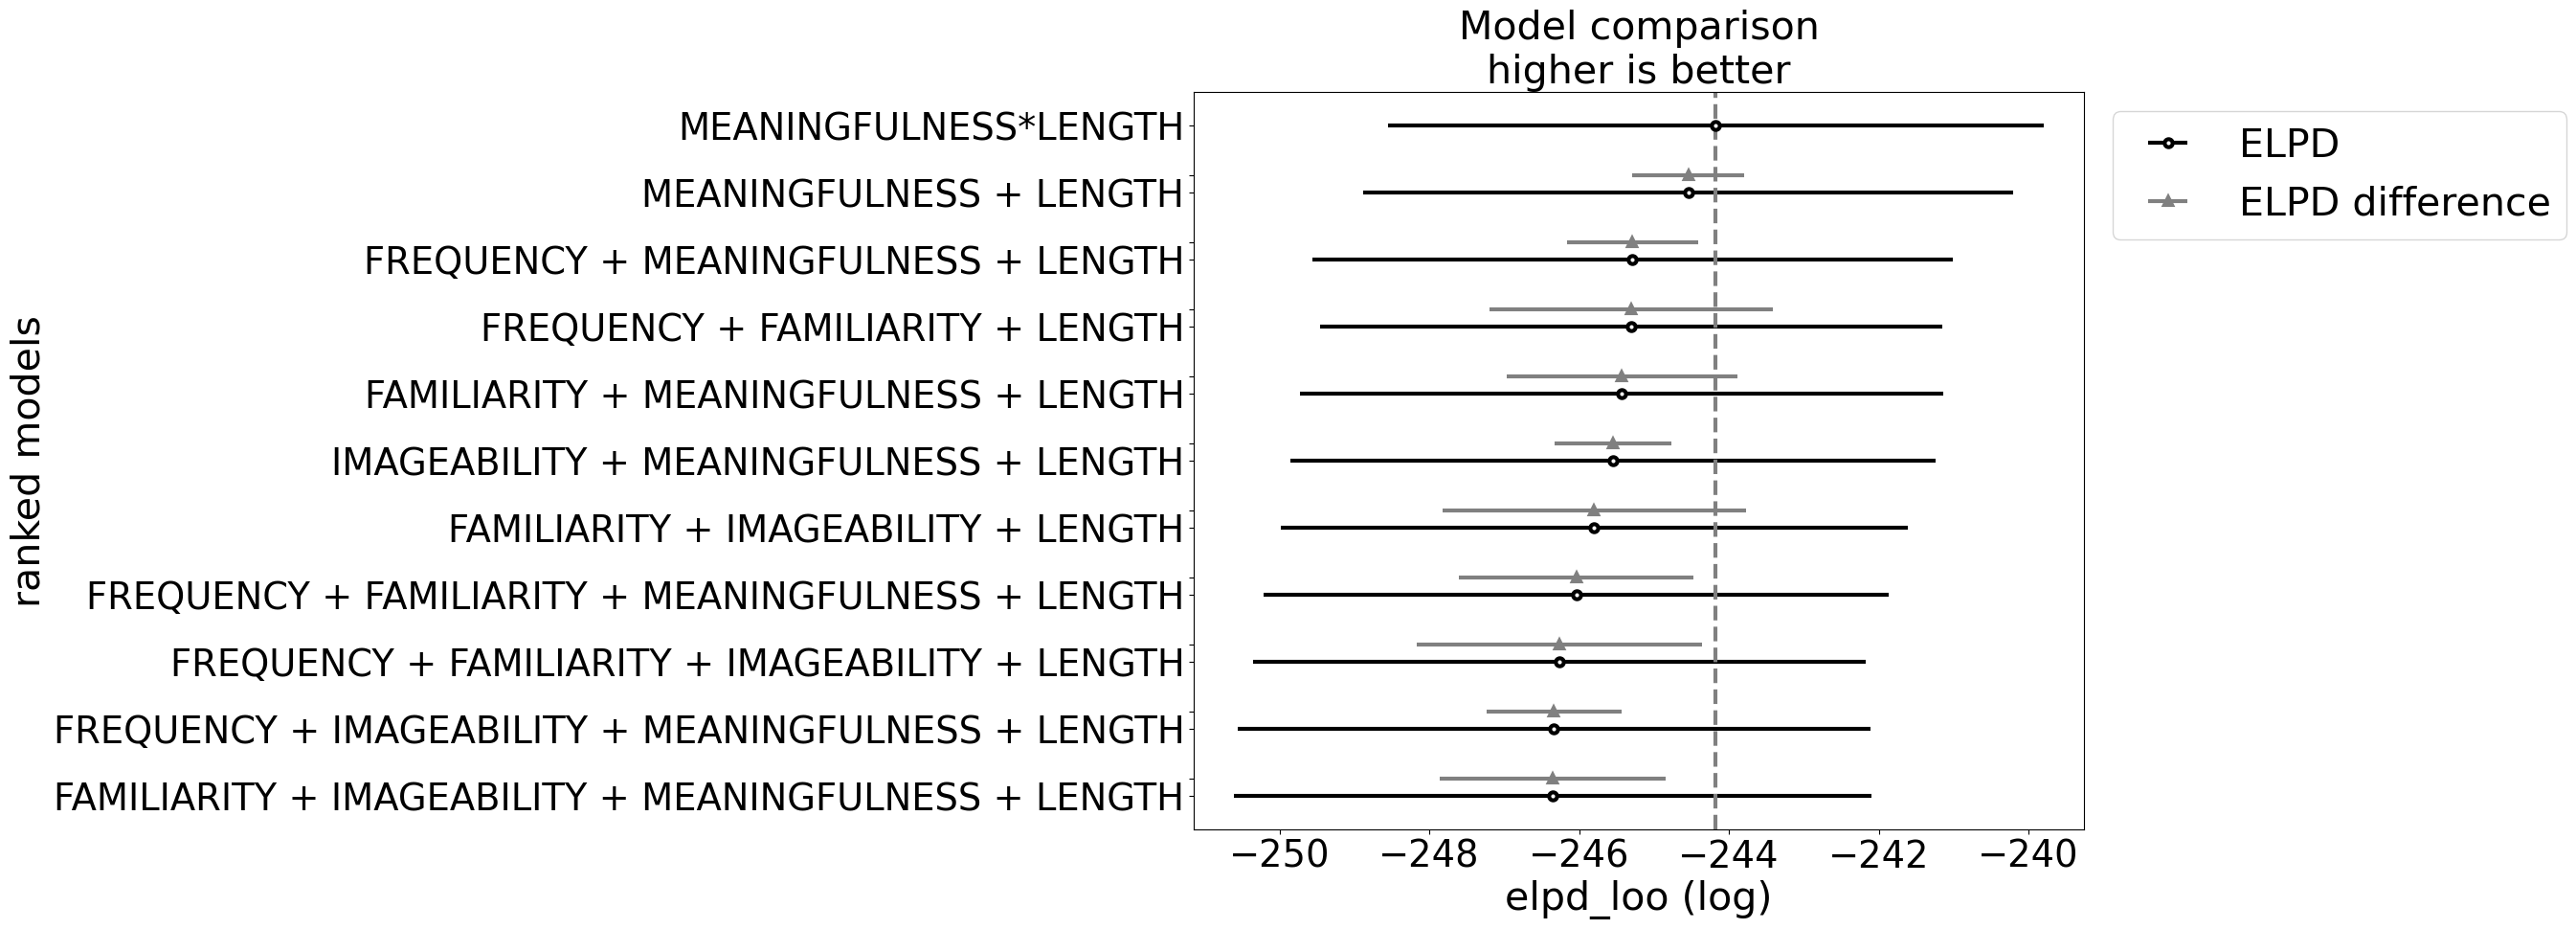

In [11]:
comp = az.compare(results)
az.plot_compare(comp, figsize=(12, 10))
plt.show()

Finally, we compare the estimates from the models for `FAMILIARITY + MEANINGFULNESS + LENGTH`. Here are the results from the statsmodels linear regression:

<pre>
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     613.6193     69.711      8.802      0.000     473.034     754.204
C(FAMILIARITY, Diff)[D.lo]    -24.3092     17.225     -1.411      0.165     -59.046      10.428
C(FAMILIARITY, Diff)[D.med]   -10.2538     14.383     -0.713      0.480     -39.260      18.753
MEANINGFULNESS                 -0.1355      0.157     -0.863      0.393      -0.452       0.181
LENGTH                         11.1608      3.006      3.713      0.001       5.099      17.222
</pre>

...and here are the results from `bambi`. As you can see, the estimates and the credible intervals (or confidence intervals on the statsmodels side) are very similar.

In [12]:
az.summary(results["FAMILIARITY + MEANINGFULNESS + LENGTH"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,37.989,4.096,30.386,45.348,0.064,0.046,4140.0,3209.0,1.0
Intercept,636.406,67.822,507.209,757.664,1.115,0.789,3697.0,2744.0,1.0
FAMILIARITY[med],-23.899,18.073,-57.978,9.701,0.333,0.243,2946.0,2883.0,1.0
FAMILIARITY[hi],-34.144,23.317,-78.987,7.938,0.455,0.322,2629.0,2881.0,1.0
MEANINGFULNESS,-0.141,0.164,-0.438,0.167,0.003,0.002,3093.0,2799.0,1.0
LENGTH,11.020,3.094,5.352,16.863,0.046,0.032,4652.0,2937.0,1.0


# In Summary...

When comparing model results you should consider BOTH the uncertainty of the models *and* their predictive accuracy.

```
Version History

Current: v1.0.0

17/11/24: 1.0.0: first draft, BN
```